In [211]:
import numpy as np
import scipy.integrate
import matplotlib.pyplot as plt
import scipy.signal

SMALL_SIZE = 12
MEDIUM_SIZE = 14
LARGE_SIZE = 16

plt.rc("font",size=LARGE_SIZE)
plt.rc("axes",titlesize=LARGE_SIZE)
plt.rc("axes",labelsize=LARGE_SIZE)
plt.rc("xtick",labelsize=LARGE_SIZE)
plt.rc("ytick",labelsize=LARGE_SIZE)
plt.rc("legend",fontsize=LARGE_SIZE)
plt.rc("figure",titlesize=LARGE_SIZE)

In [212]:
### Physical Constant ###
### DO NOT EDIT ###

# Specific Ionic constants     (l/g_ion)

HNa  = -0.550
HCa  = -0.303
HMg  = -0.314
HH   = -0.774
HCl  =  0.844
HCO3 =  0.485
HHO  =  0.941


# Molecular masses     (g/mol)

MNaCl  = 58.5
MCaCO3 = 90
MMgCl2 = 95
MNa    = 23
MCa    = 40
MMg    = 24
MCl    = 35.5
MCO3   = 60 


# Kinetic constants
   
miu_P  = 1.790      # [1/h]
Ks     = 1.030      # [g/l]
Ks1    = 1.680      # [g/l]      
Kp     = 0.139      # [g/l]
Kp1    = 0.070      # [g/l]
Rsx    = 0.607
Rsp    = 0.435
YO2    = 0.970      # [mg/mg]
KO2    = 8.86       # [mg/l]
miu_O2 = 0.5        # [1/h]
A1     = 9.5e8
A2     = 2.55e33
Ea1    = 55000      # J/mol
Ea2    = 220000     # J/mol
R      = 8.31       # J/(mol.K)


# thermodynamic constants

Kla0   = 38        # [1/h]
KT     = 100*3600  # [J/hm2K]
Vm     = 50        # [l]
AT     = 1         # [m2]
ro     = 1080      # [g/l]
ccal   = 4.18      # [J/gK]         
roag   = 1000      # [g/l]
ccalag = 4.18      # [J/gK]
deltaH = 518       # [kJ/mol O2 consumat]

 
# Initial data

mNaCl  = 500        # [g]
mCaCO3 = 100        # [g]
mMgCl2 = 100        # [g]
pH     = 6
Tiag   = 15         # [癈]


# Initial Conditions

x0 = [1000, 0.90467678228155, 12.51524128083789, 29.73892382828279, 3.10695341758232, 29.57321214183856, 27.05393890970931]


In [213]:
### Process Model Function ###
### DO NOT EDIT ###
global T_POINT, T_DELAY
T_POINT = 100 ## number of point to sample with in 1 step
T_DELAY = 3   ## time delay of the system

def model(t,vars,Fi,Fe,T_in,cS_in,Fag):
    V, cX, cP, cS, cO2, T, Tag = vars
    t_index = np.mod(t,1)
    t_index = int(t_index*T_POINT)
    ## handle both function and a list
    if callable(Fi):
        Fi = Fi(t)
    else:
        Fi = Fi[t_index]
    if callable(Fe):
        Fe = Fe(t)
    else:
        Fe = Fe[t_index]
    if callable(T_in):
        T_in = T_in(t)
    else:
        T_in = T_in[t_index]
    if callable(cS_in):
        cS_in = cS_in(t)
    else:
        cS_in = cS_in[t_index]
    if callable(Fag):
        Fag = Fag(t)
    else:
        Fag = Fag[t_index]

    c0st = 14.16 - 0.3943 * T + 0.007714 * T**2 - 0.0000646 * T**3 # [mg/l]
    
    cNa  = mNaCl/MNaCl*MNa/V
    cCa  = mCaCO3/MCaCO3*MCa/V
    cMg  = mMgCl2/MMgCl2*MMg/V
    cCl  = (mNaCl/MNaCl + 2*mMgCl2/MMgCl2)*MCl/V
    cCO3 = mCaCO3/MCaCO3*MCO3/V
    cH   = 10**(-pH)
    cOH  = 10**(-(14-pH))

    INa  = 0.5*cNa*((+1)**2)
    ICa  = 0.5*cCa*((+2)**2)
    IMg  = 0.5*cMg*((+2)**2)
    ICl  = 0.5*cCl*((-1)**2)
    ICO3 = 0.5*cCO3*((-2)**2)
    IH   = 0.5*cH*((+1)**2)
    IOH  = 0.5*cOH*((-1)**2)

    sumaHiIi = HNa*INa+HCa*ICa+HMg*IMg+HCl*ICl+HCO3*ICO3+HH*IH+HHO*IOH
    cst  = c0st * 10**(-sumaHiIi)
    Kla  = Kla0*(1.024**(T-20))
    rO2 = miu_O2 * cO2 * cX/YO2/(KO2 + cO2)*1000  # mg/lh
    miu_X = A1*np.exp(-Ea1/R/(T+273)) - A2*np.exp(-Ea2/R/(T+273))

    dV   = Fi - Fe
    dcX  = miu_X * cX * cS / (Ks + cS) * np.exp(-Kp * cP) - (Fe/V)*cX     # g/(l.h)
    dcP  = miu_P * cX * cS / (Ks1 + cS) * np.exp(-Kp1 * cP) - (Fe/V)*cP   # g/(l.h)
    dcS  = - miu_X * cX * cS / (Ks + cS) * np.exp(-Kp * cP) / Rsx - miu_P * cX * cS / (Ks1 + cS) * np.exp(-Kp1 * cP) / Rsp + (Fi/V)*cS_in - (Fe/V)*cS                                    # g/(l.h)
    dcO2 = Kla * (cst - cO2) - rO2 - (Fe/V)*cO2                        # mg/(l.h)
    dT   = (1/32*V*rO2*deltaH - KT*AT*(T - Tag) + Fi*ro*ccal*(T_in+273) - Fe*ro*ccal*(T+273))/(ro*ccal*V)    # J/h
    dTag = (Fag*ccalag*roag*(Tiag - Tag) + KT*AT*(T - Tag)) / (Vm * roag * ccalag)                                        # J/h

    return [dV, dcX, dcP, dcS, dcO2, dT, dTag]


In [214]:
### If you are interested, the simulation is achieved by runing the model without the time delay and mannully shift the time for the model.
### The feedback is achieved by accessing the process output on previous time (time delay enables this).

## solve one step of the model, time is an array [t_initial, t_end]
def solve_step(time, x0, Fi, Fe, T_in, cS_in, Fag, result):
    t_eval = np.linspace(time[0],time[1],T_POINT)
    ### changed to BDF method stablized the oxygen concentration
    sol = scipy.integrate.solve_ivp(model, time, x0,args=(Fi,Fe,T_in,cS_in,Fag), t_eval=t_eval, method='BDF')
    if time[0] == 0:
        result = np.concatenate((result, sol.y), axis=1)
    else:
        result = np.concatenate((result, sol.y[:,1:]), axis=1)

    return result

## Find the current output of your system time is integer and returns the process data for 1 step with number of point equal to T_POINT
def current_output(time, result):
    process_time = int(time*(T_POINT-1))
    return result[:,process_time:int((time+1)*(T_POINT-1)+1)]

## Find the setpoint of your process.
def set_point(time, x0):
    result = np.zeros([7,T_DELAY*(T_POINT-1)])
    for i in range(time[1]-T_DELAY):
        if i == 0:
            x0=x0
        Fi = lambda t: 51
        Fe = lambda t: 51
        T_in = lambda t: 25
        cS_in = lambda t: 60
        Fag = lambda t: 18
        result = solve_step([i, i+1], x0, Fi, Fe, T_in, cS_in, Fag, result)
        x0 = result[:,-1]
    return result

In [215]:
## Function that runs the entie feedback loop. time is an array with [t_inital, t_end], x0 is the initial condition
def dynamic_model(time, x0):
    result_sp = set_point(time, x0)
    result = np.zeros([7,T_DELAY*(T_POINT-1)])
    for i in range(time[1]-T_DELAY):
        ##Cover the edge case
        if i == 0:
            x0=x0

        V, Cx, Cp, Cs, Co2, T, Tag = current_output(i,result) # find the current output of the process
        Vsp, Cxsp, Cpsp, Cssp, Co2sp, Tsp, Tagsp = current_output(i,result_sp) # Find the current setpoint of the process
        ## process input, you may need to specify as disturbance in the problem statement or you need to use controller to adjust the input
        Fi = lambda t: 51
        Fe = lambda t: 51
        T_in = lambda t: 25
        cS_in = lambda t: 60
        Fag = lambda t: 18

        ## Find your error

        ## Construct your transfer function


        t_eval = np.linspace(i,i+1,T_POINT) ## your transfer function should evaluate on the same time point as the model (this is your sampling point)
        
        ## Simulate your input to the model
       
        ## Your solve_step can take both a callable function for Fi, Fe, T_in, cS_in, Fag or an array of data at the given [i, i+1] time window.
        ## ie your simulated input to process can be directly feed into the solve_step, and you can also define disturbance as function and pass into the solve_step
        result = solve_step([i, i+1], x0, Fi, Fe, T_in, cS_in, Fag, result)
        x0 = result[:,-1]
    t = np.linspace(time[0],time[1],(time[1] - time[0])*(T_POINT-1)+1) ## entire sampling time for the process 
    return t, result, result_sp


In [216]:
t_final = 100 ### final time for you model
t, result, result_sp = dynamic_model([0,t_final], x0) ### run the model

### Notice, you may find offest when you do you controller, and we are trying to identiy if that's
### what pthon do or there is a small bug on the code, but it shouldn't affect your design.

<>:43: SyntaxWarning: invalid escape sequence '\c'
<>:50: SyntaxWarning: invalid escape sequence '\c'
<>:43: SyntaxWarning: invalid escape sequence '\c'
<>:50: SyntaxWarning: invalid escape sequence '\c'
/var/folders/_s/gyy2hzx57s90tk86zfdrv0p40000gn/T/ipykernel_4900/3162908226.py:43: SyntaxWarning: invalid escape sequence '\c'
  plt.ylabel("Tank Temperature ($^{\circ} C$)")
/var/folders/_s/gyy2hzx57s90tk86zfdrv0p40000gn/T/ipykernel_4900/3162908226.py:50: SyntaxWarning: invalid escape sequence '\c'
  plt.ylabel("Cooling Water Temperature ($^{\circ} C$)")


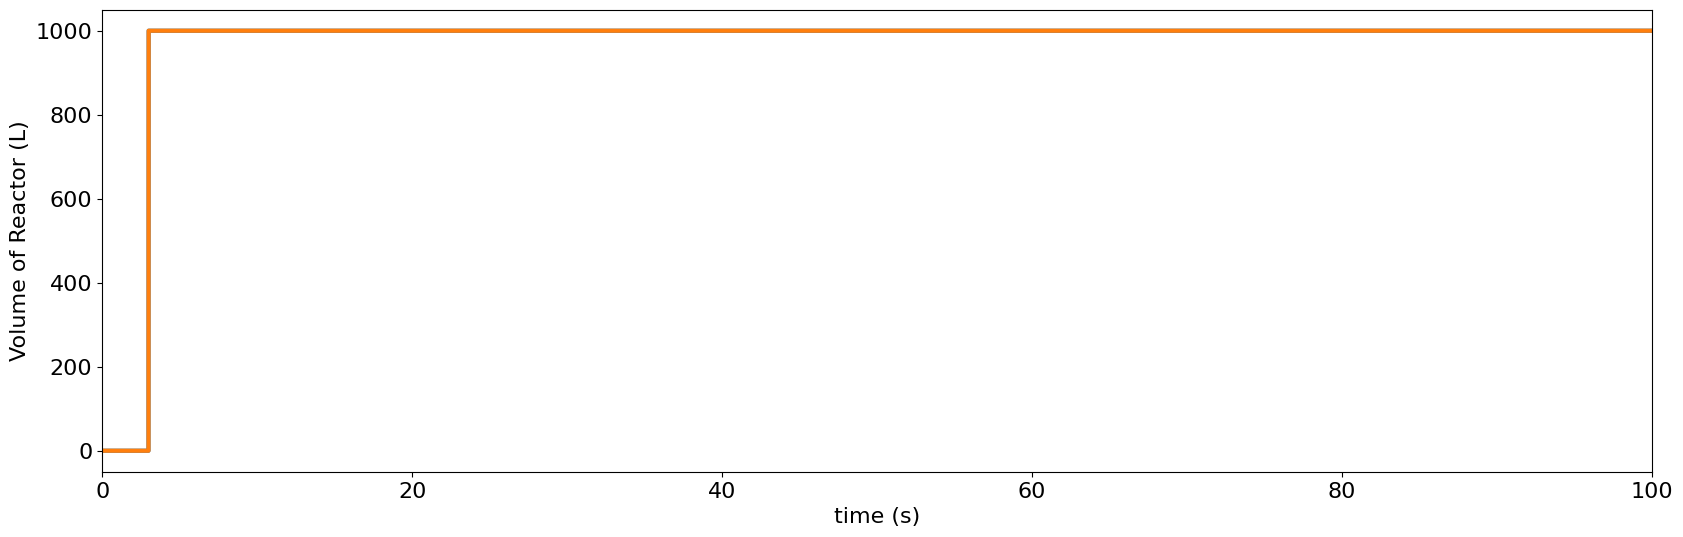

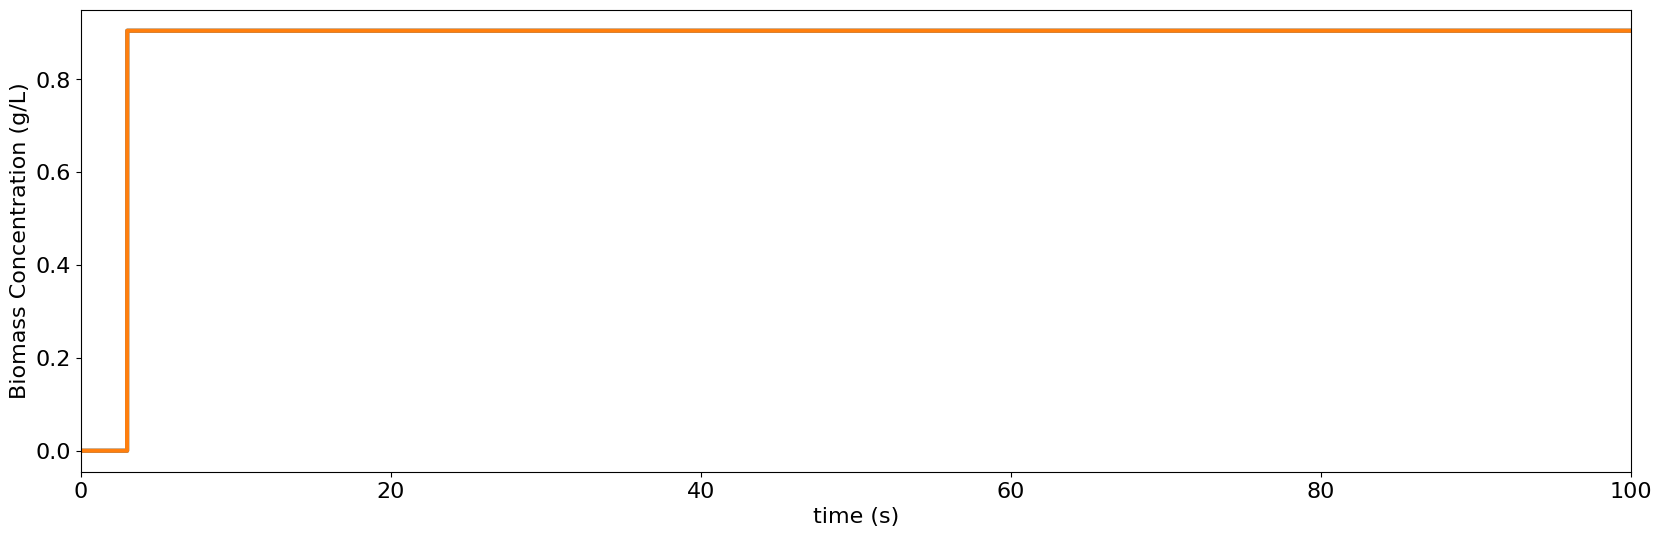

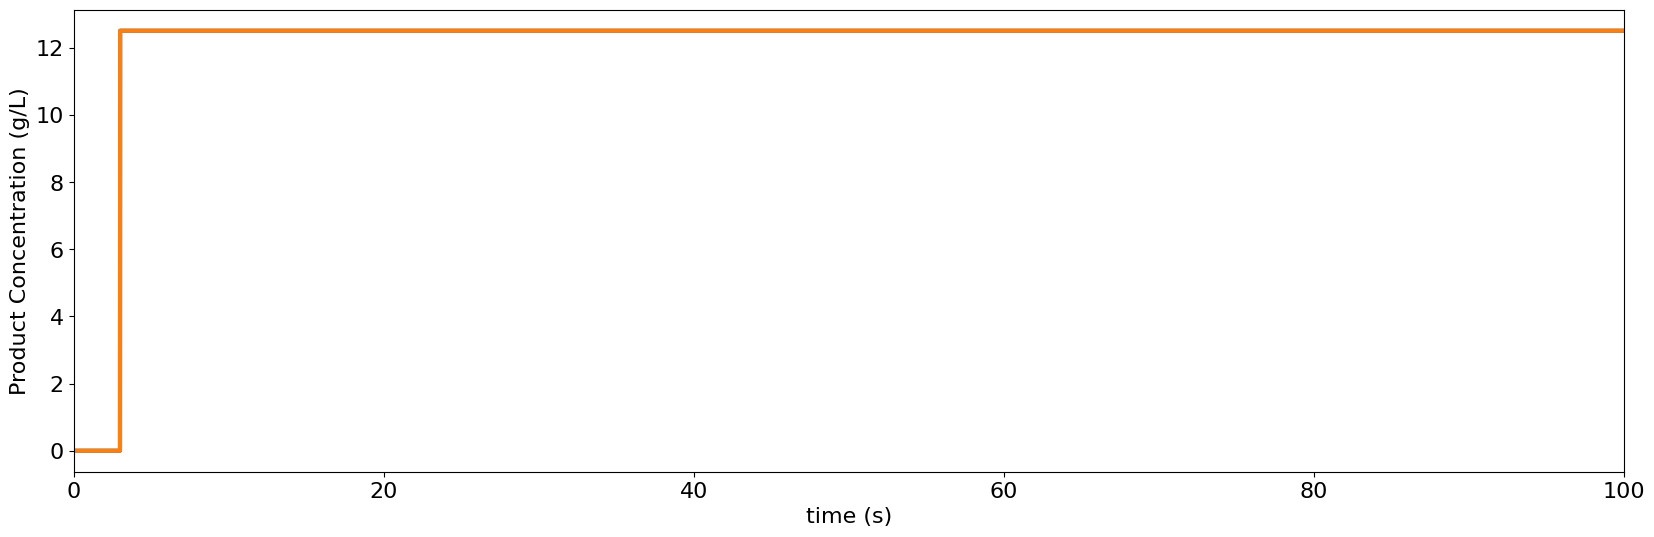

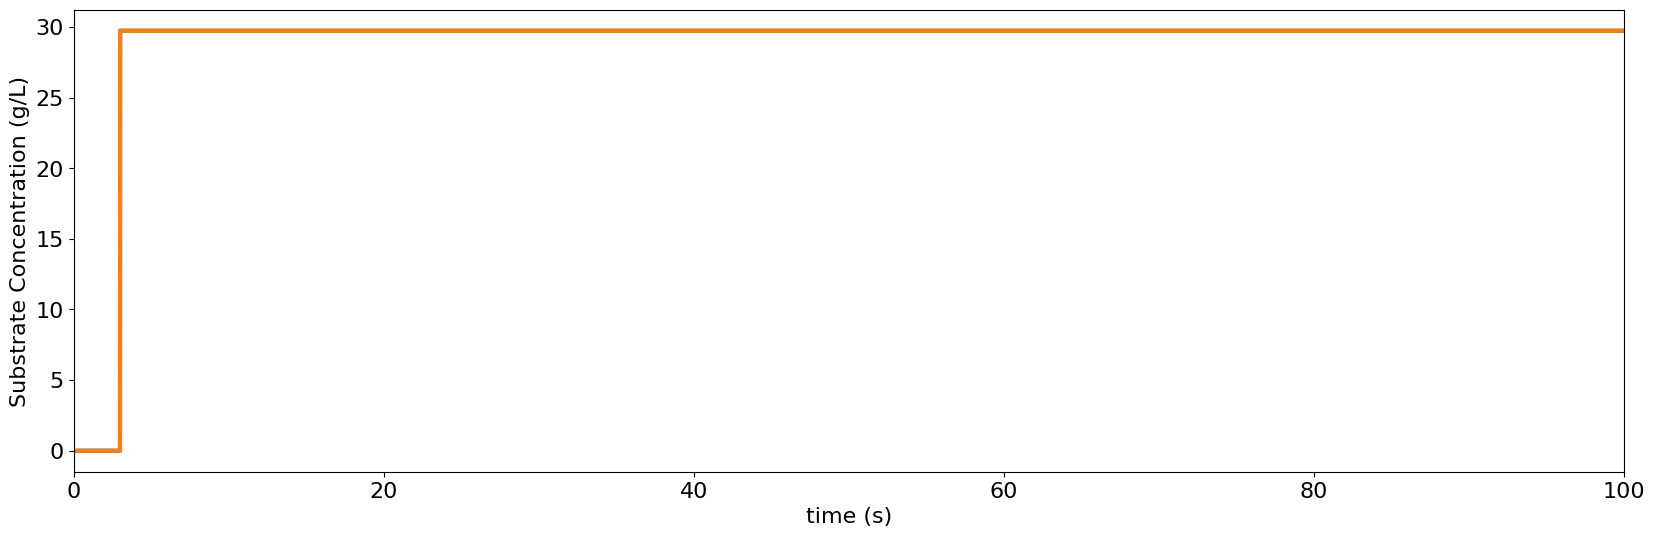

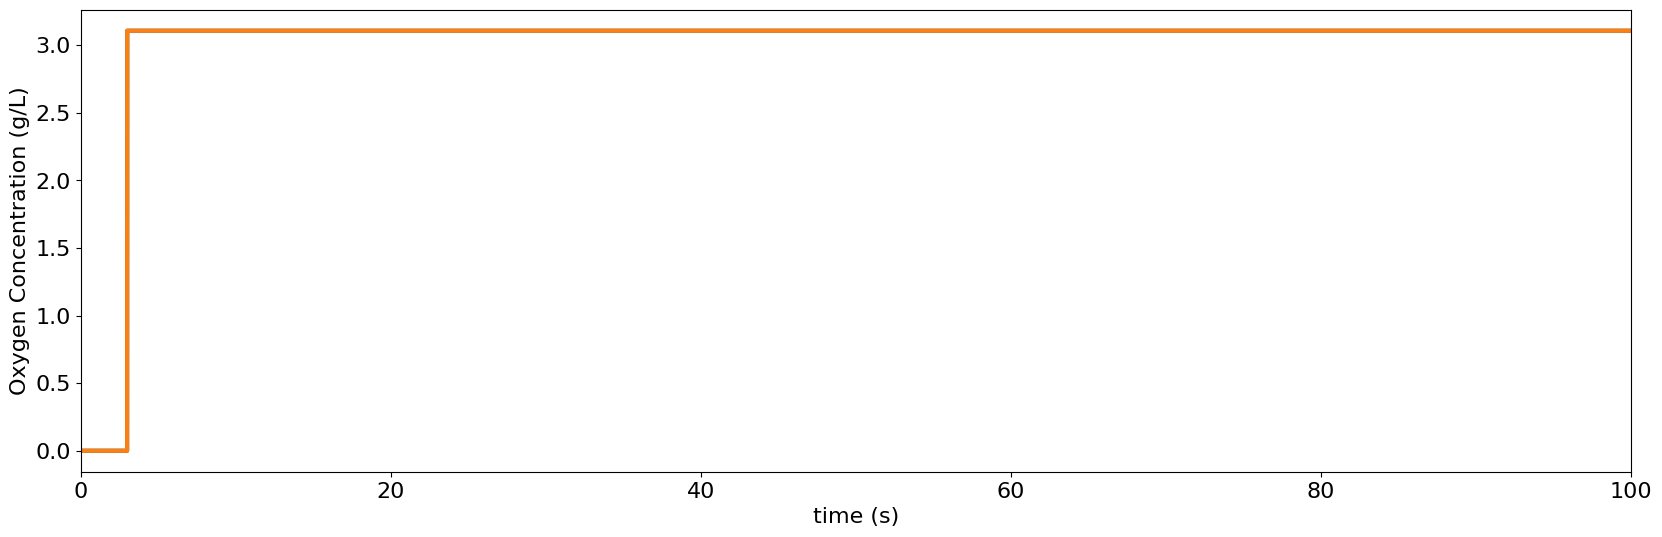

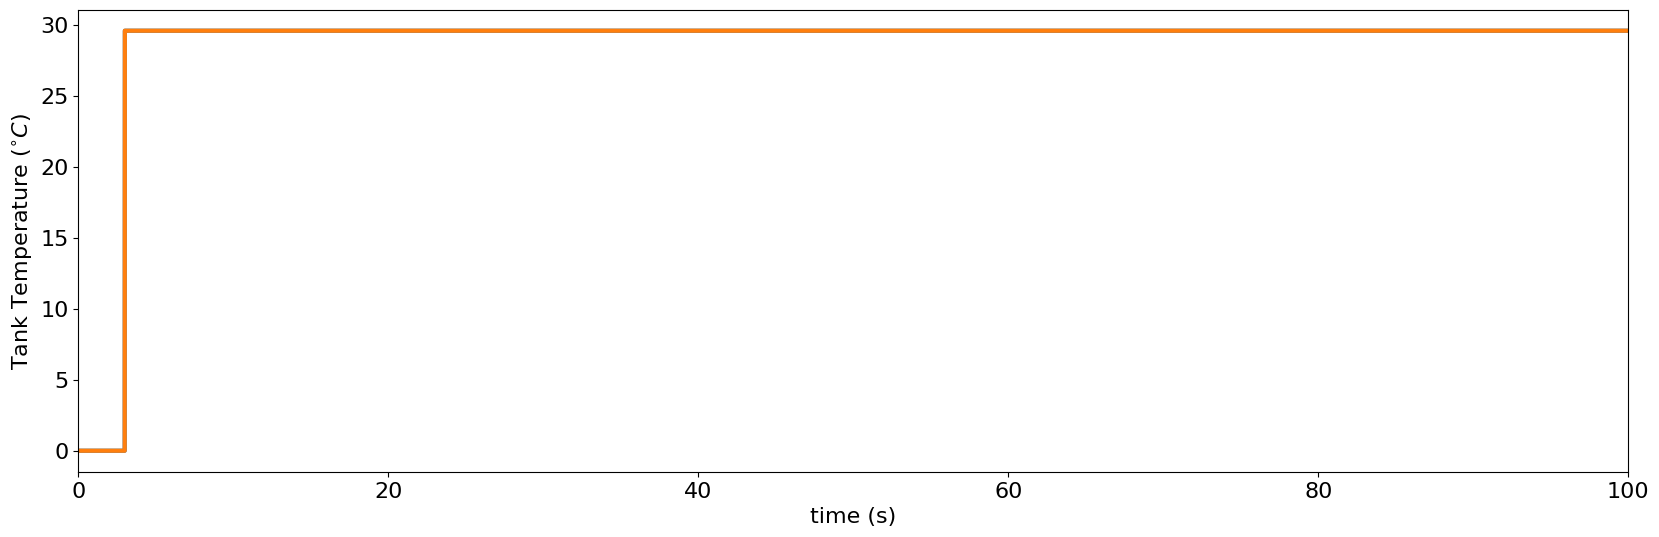

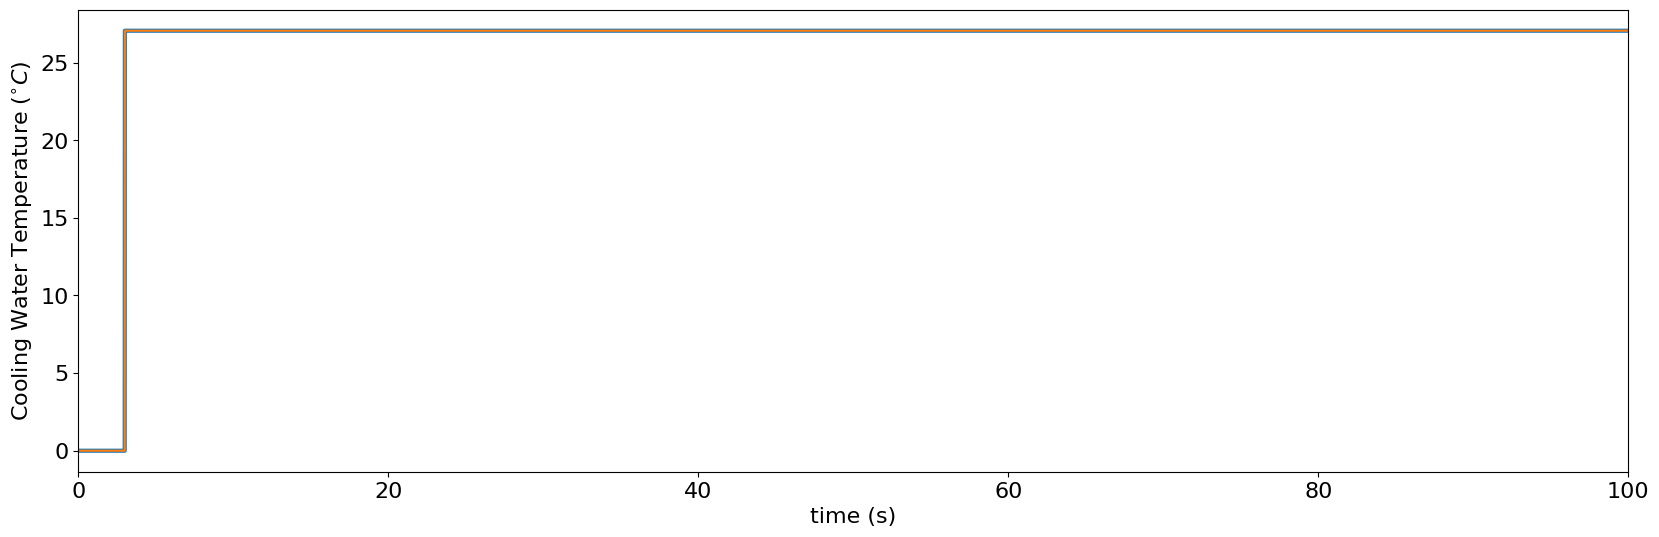

In [217]:
### Ploting ###

plt.figure(figsize=(20, 6))
plt.plot(t,result[0],lw=3)
plt.plot(t,result_sp[0],lw=3)
plt.xlim([0,t_final])
plt.xlabel("time (s)")
plt.ylabel("Volume of Reactor (L)")

plt.figure(figsize=(20, 6))
plt.plot(t,result[1],lw=3)
plt.plot(t,result_sp[1],lw=3)
plt.xlim([0,t_final])
plt.xlabel("time (s)")
plt.ylabel("Biomass Concentration (g/L)")

plt.figure(figsize=(20, 6))
plt.plot(t,result[2],lw=3)
plt.plot(t,result_sp[2],lw=3)
plt.xlim([0,t_final])
plt.xlabel("time (s)")
plt.ylabel("Product Concentration (g/L)")

plt.figure(figsize=(20, 6))
plt.plot(t,result[3],lw=3)
plt.plot(t,result_sp[3],lw=3)
plt.xlim([0,t_final])
plt.xlabel("time (s)")
plt.ylabel("Substrate Concentration (g/L)")

plt.figure(figsize=(20, 6))
plt.plot(t,result[4],lw=3)
plt.plot(t,result_sp[4],lw=3)
plt.xlim([0,t_final])
plt.xlabel("time (s)")
plt.ylabel("Oxygen Concentration (g/L)")

plt.figure(figsize=(20, 6))
plt.plot(t,result[5],lw=3)
plt.plot(t,result_sp[5],lw=3)
plt.xlim([0,t_final])
plt.xlabel("time (s)")
plt.ylabel("Tank Temperature ($^{\circ} C$)")

plt.figure(figsize=(20, 6))
plt.plot(t,result[6],lw=3)
plt.plot(t,result_sp[6])
plt.xlim([0,t_final])
plt.xlabel("time (s)")
plt.ylabel("Cooling Water Temperature ($^{\circ} C$)")
plt.show()


## Question 3

Let's see the difference in the product concentration with disturbances to $C_s$ vs. $T$

In [218]:
x0_baseline = [1000, 0.90467678228155, 12.51524128083789, 29.73892382828279, 3.10695341758232, 29.57321214183856, 27.05393890970931]

x0_disturb_cs = x0_baseline.copy()
x0_disturb_cs[3] += 5

x0_disturb_temp = x0_baseline.copy()
x0_disturb_temp[5] += 2

t_final = 100

t_baseline, result_baseline, _ = dynamic_model([0, t_final], x0_baseline)
t_cs, result_cs, _ = dynamic_model([0, t_final], x0_disturb_cs)
t_temp, result_temp, _ = dynamic_model([0, t_final], x0_disturb_temp)

T_baseline, T_cs, T_temp = result_baseline[5, :], result_cs[5, :], result_temp[5, :]
Cp_baseline, Cp_cs, Cp_temp = result_baseline[2, :], result_cs[2, :], result_temp[2, :]


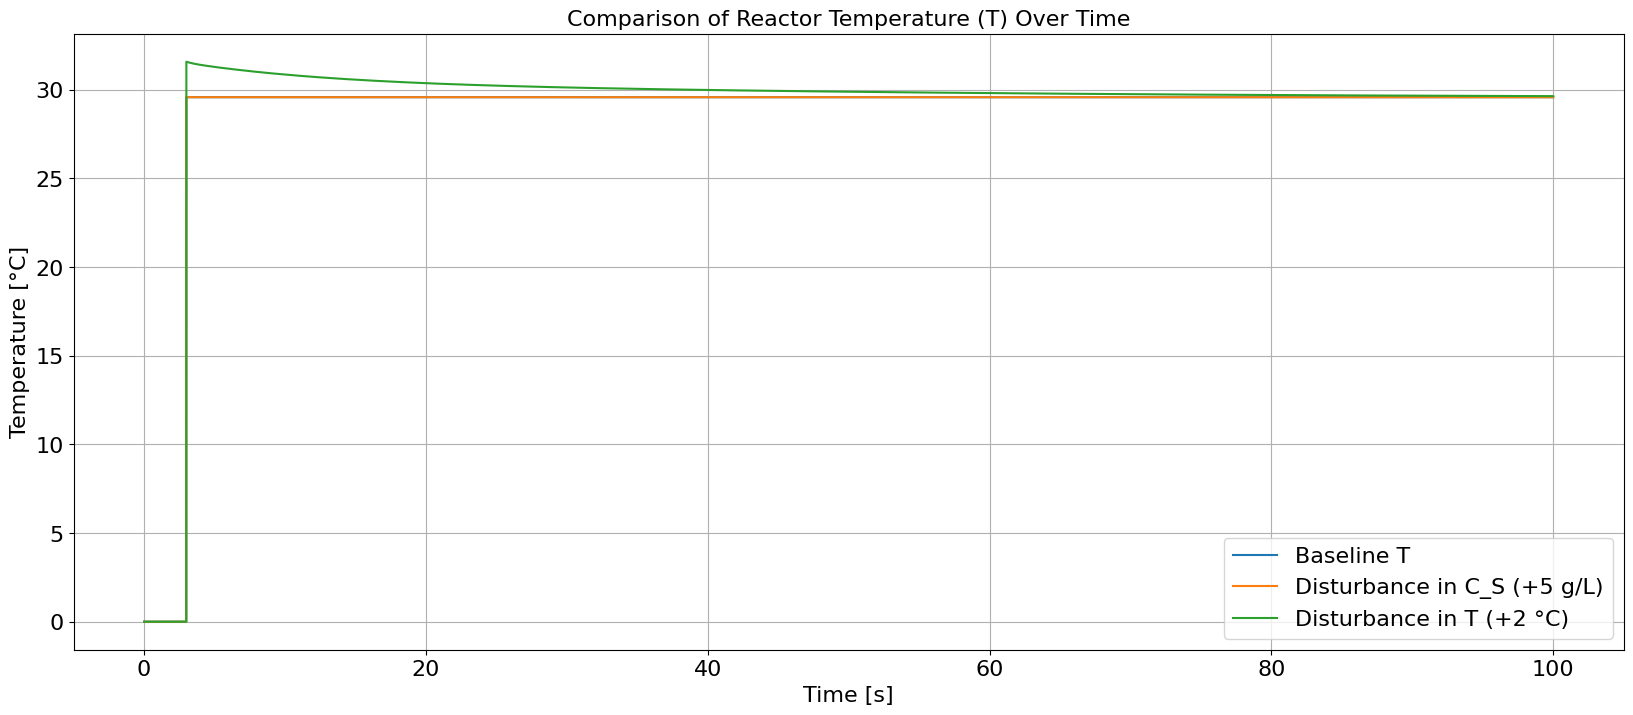

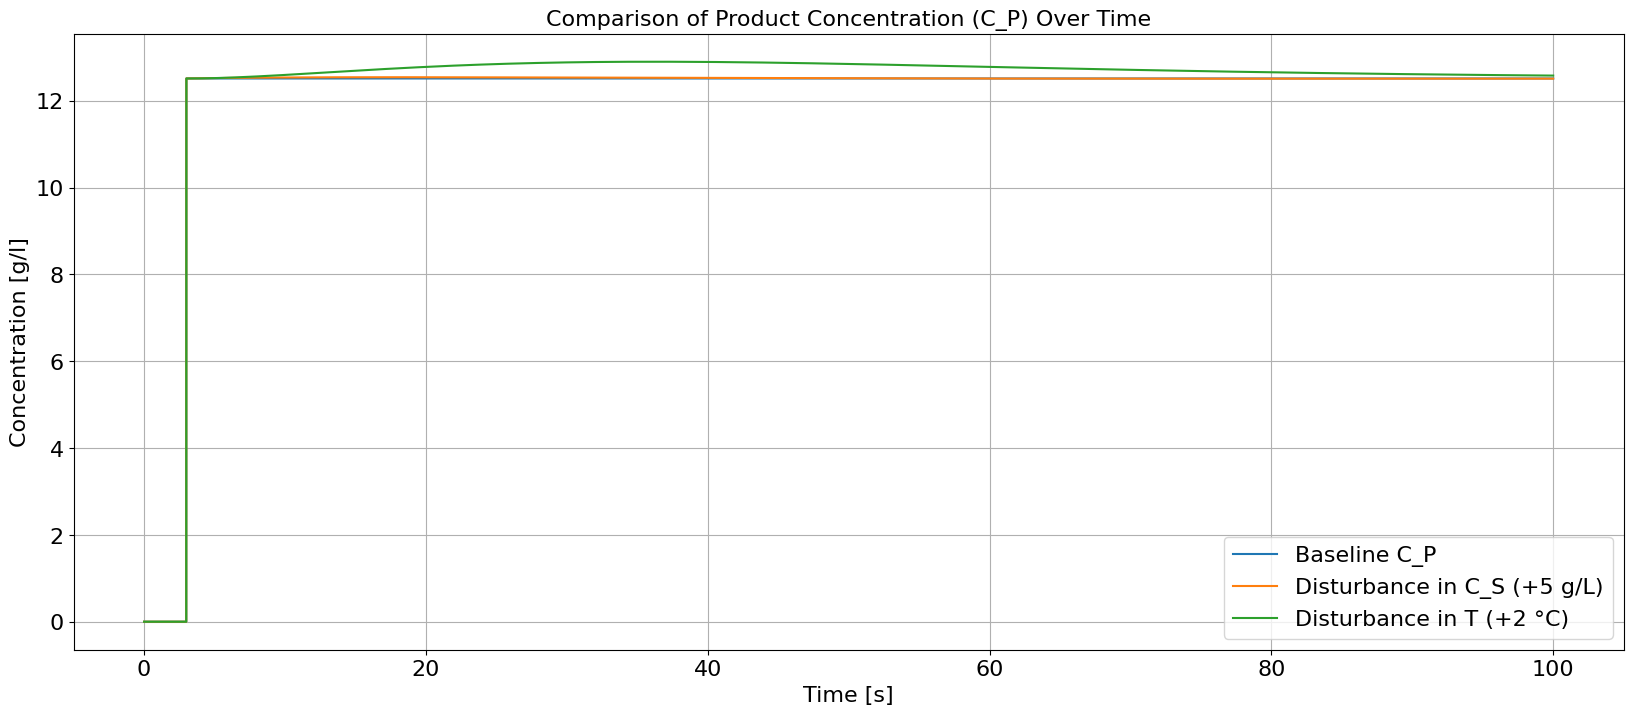

In [219]:
plt.figure(figsize=(20, 8))
plt.plot(t_baseline, T_baseline, label="Baseline T")
plt.plot(t_cs, T_cs, label="Disturbance in C_S (+5 g/L)")
plt.plot(t_temp, T_temp, label="Disturbance in T (+2 °C)")
plt.title("Comparison of Reactor Temperature (T) Over Time")
plt.xlabel("Time [s]")
plt.ylabel("Temperature [°C]")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(20, 8))
plt.plot(t_baseline, Cp_baseline, label="Baseline C_P")
plt.plot(t_cs, Cp_cs, label="Disturbance in C_S (+5 g/L)")
plt.plot(t_temp, Cp_temp, label="Disturbance in T (+2 °C)")
plt.title("Comparison of Product Concentration (C_P) Over Time")
plt.xlabel("Time [s]")
plt.ylabel("Concentration [g/l]")
plt.legend()
plt.grid(True)
plt.show()


We will also get the percentage difference for a quantitative difference in $T$ and $C_P$ as a result of the disturbance in $T_f$ and $C_S$ at the feed

In [220]:
baseline_T = result_baseline[5, -1]
csin_T = result_cs[5, -1]
temp_T = result_temp[5, -1]

baseline_Cp = result_baseline[2, -1]
csin_Cp = result_cs[2, -1]
temp_Cp = result_temp[2, -1]

In [221]:
def percent_change(baseline, disturbed):
    return ((disturbed - baseline) / baseline) * 100

percent_change_T_csin = percent_change(baseline_T, csin_T)
percent_change_T_temp = percent_change(baseline_T, temp_T)

percent_change_Cp_csin = percent_change(baseline_Cp, csin_Cp)
percent_change_Cp_temp = percent_change(baseline_Cp, temp_Cp)

print(f"Percent change in T for disturbance in C_S (+20 g/L): {percent_change_T_csin:.2f}%")
print(f"Percent change in T for disturbance in T (-2°C): {percent_change_T_temp:.2f}%")
print(f"Percent change in C_P for disturbance in C_S (+20 g/L): {percent_change_Cp_csin:.2f}%")
print(f"Percent change in C_P for disturbance in T (-2°C): {percent_change_Cp_temp:.2f}%")


Percent change in T for disturbance in C_S (+20 g/L): -0.01%
Percent change in T for disturbance in T (-2°C): 0.20%
Percent change in C_P for disturbance in C_S (+20 g/L): -0.03%
Percent change in C_P for disturbance in T (-2°C): 0.53%


## Question 4

In [222]:
step_index = 5
def dynamic_model_with_step_Fe(time, x0):
    result_sp = set_point(time, x0)
    result = np.zeros((7, T_DELAY * (T_POINT - 1)))
    
    for i in range(time[1] - T_DELAY):
        if i == 0:
            x0 = x0
        
        V, Cx, Cp, Cs, Co2, T, Tag = current_output(i, result)
        Vsp, Cxsp, Cpsp, Cssp, Co2sp, Tsp, Tagsp = current_output(i, result_sp)
        
        Fi = lambda t: 51
        Fe = lambda t: 51 if t < step_index else 51 * 1.1
        T_in = lambda t: 25
        cS_in = lambda t: 60
        Fag = lambda t: 18
        
        result = solve_step([i, i + 1], x0, Fi, Fe, T_in, cS_in, Fag, result)
        x0 = result[:, -1]
    
    t = np.linspace(time[0], time[1], (time[1] - time[0]) * (T_POINT - 1) + 1)
    return t, result, result_sp


In [223]:
t_final = 100
t_step, result_step, result_sp_step = dynamic_model_with_step_Fe([0, t_final], x0)
V_step = result_step[0, :]

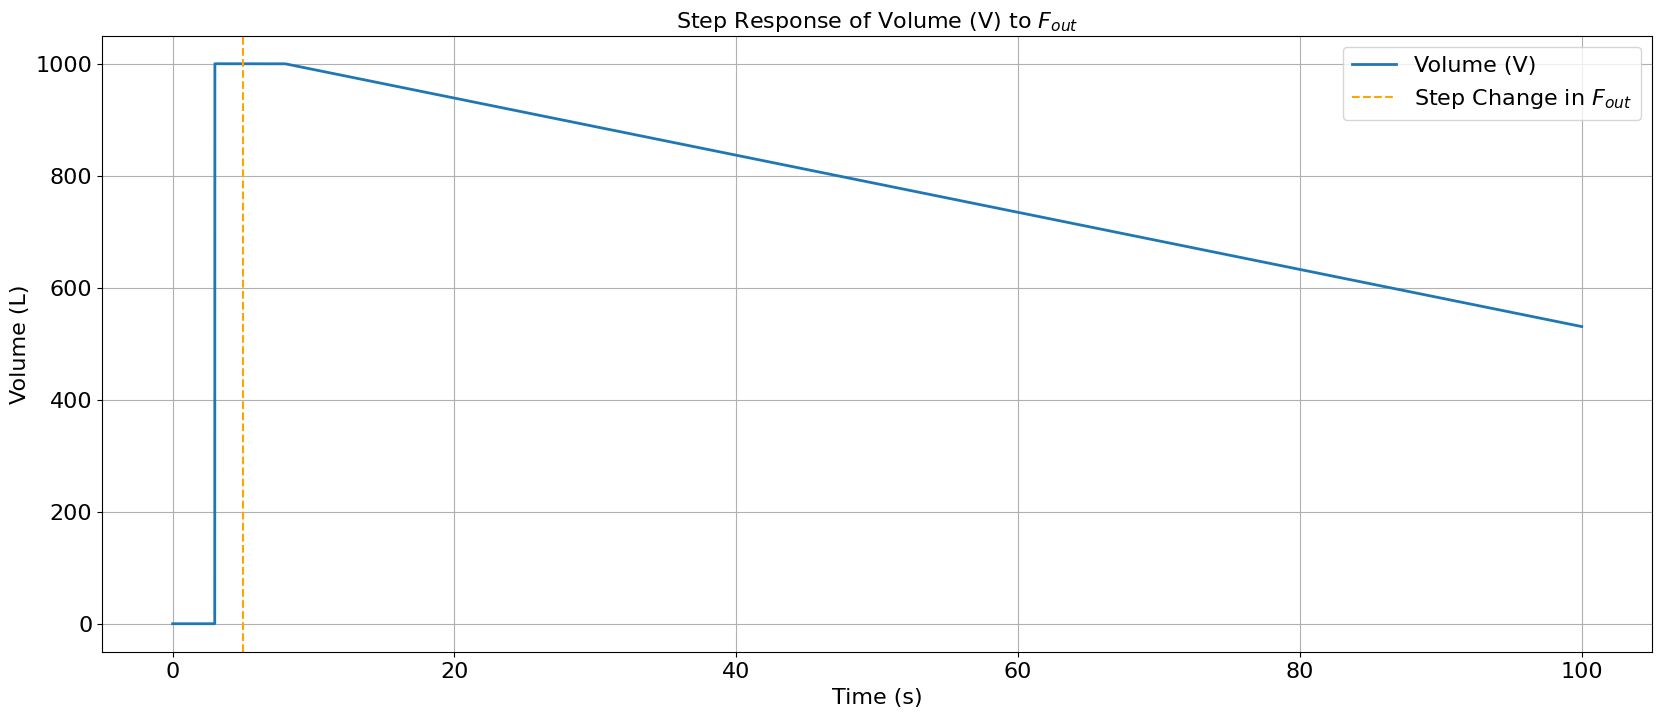

In [224]:
plt.figure(figsize=(20, 8))
plt.plot(t_step, V_step, label="Volume (V)", linewidth=2)
plt.axvline(step_index, color='orange', linestyle='--', label="Step Change in $F_{out}$")
plt.title("Step Response of Volume (V) to $F_{out}$")
plt.xlabel("Time (s)")
plt.ylabel("Volume (L)")
plt.legend()
plt.grid(True)
plt.show()

#### Attempt 1 at finding PID Parameters

In [248]:
V_step = result_step[0, :]

delta_F_out = 51 * 0.1
delta_V = -1000
K = delta_V / delta_F_out
theta = 3
tauc = 3

# target_value = 1000 + 0.63 * delta_V
# time_to_63 = t_step[np.where(V_step >= target_value)[0][0]]

# threshold = 0.01 * delta_V
# time_delay_index = np.where(V_step > V_step[0] + threshold)[0][0]
# time_delay = t_step[time_delay_index]

print(f"Steady-State Gain (K): {K} L/(L/h)")
# print(f"Time Delay (theta): {time_delay} s")
# print(f"Time Constant (tau): {time_to_63 - time_delay} s")

# we set time constant (tau, lambda) equal to time delay via ziegler-nichols method
kc = (2* tauc + theta) / (K * (tauc + theta) ** 2)
print(kc)
tau_i = 2 * tauc + theta
print(tau_i)

Steady-State Gain (K): -196.078431372549 L/(L/h)
-0.001275
9


#### Attempt 2's time delay makes sense with the plot. However, I think attempt 1 is more accurate because it depicts an accurate negative gain and uses an initial volume of 1000 instead of 1. I believe the plot is flawed. 

In [272]:
F_out_min, F_out_max = 0, 100
integral_min, integral_max = -10, 10
Kp = kc
Ki = kc / tau_i

def FC(V, V_SP, F_out0, Kp, Ki, integral_error, dt):
    error = V_SP - V
    integral_error += error * dt
    integral_error = np.clip(integral_error, integral_min, integral_max)
    F_out = F_out0 + Kp * error + Ki * integral_error
    print(Kp * error + Ki * integral_error)
    return F_out, integral_error

In [282]:
V_SP = 1000
F_out0 = 51
integral_error = 0

def dynamic_model_with_PI(time, x0):
    result = np.zeros([7, T_DELAY * (T_POINT - 1)])
    result_sp = set_point(time, x0)

    dt = T_POINT
    global integral_error
    integral_error = 0

    Fi = lambda t: 51
    T_in = lambda t: 25
    cS_in = lambda t: 60
    Fag = lambda t: 18

    for i in range(time[1] - T_DELAY):
        if i == 0:
            x0 = x0

        V, _, _, _, _, _, _ = current_output(i, result)
        F_out, integral_error = FC(V[0], V_SP, F_out0, Kp, Ki, integral_error, dt)

        if not np.isfinite(F_out):
            raise ValueError("F_out became NaN or inf.")

        Fe = lambda t: F_out

        result = solve_step([i, i + 1], x0, Fi, Fe, T_in, cS_in, Fag, result)
        x0 = result[:, -1]

    t = np.linspace(time[0], time[1], (time[1] - time[0]) * (T_POINT - 1) + 1)
    return t, result

In [283]:
t_final = 500
t_PI, result_PI = dynamic_model_with_PI([0, t_final], x0)

V_PI = result_PI[0, :]
F_out_PI = 51 + Kp * (V_SP - V_PI) + Ki * np.cumsum(V_SP - V_PI) * (t_PI[1] - t_PI[0])

-1.2764166666666668
-1.2764166666666668
-1.2764166666666668
-0.0014166666666666668
0.003044097916666426
0.004671529166666331
0.00629896041666609
0.006300766666666313
0.006296885441822376
0.006290929242134869
0.006282898067603939
0.006274864590103828
0.006266836061165715
0.006258815126381986
0.006250804431345891
0.006242803978993409
0.006234813763015559
0.006226833773729489
0.006218863998079631
0.0062109044230063614
0.006202955035458318
0.0061950158223970375
0.006187086770799424
0.006179167867660063
0.006171259099989775
0.006163360454816198
0.006155471919183491
0.006147593480152336
0.006139725124799655
0.006131866840219904
0.006124018613522905
0.006116180431835731
0.006108352282301688
0.0061005341520804605
0.006092726028348114
0.006084927898297819
0.006077139749138108
0.00606936156809433
0.006061593342408067
0.006053835059337716
0.0060460867061574745
0.006038348270158353
0.006030619738647018
0.006022901098946512
0.006015192338395973
0.0060074934443513466
0.005999804404184674
0.005992125

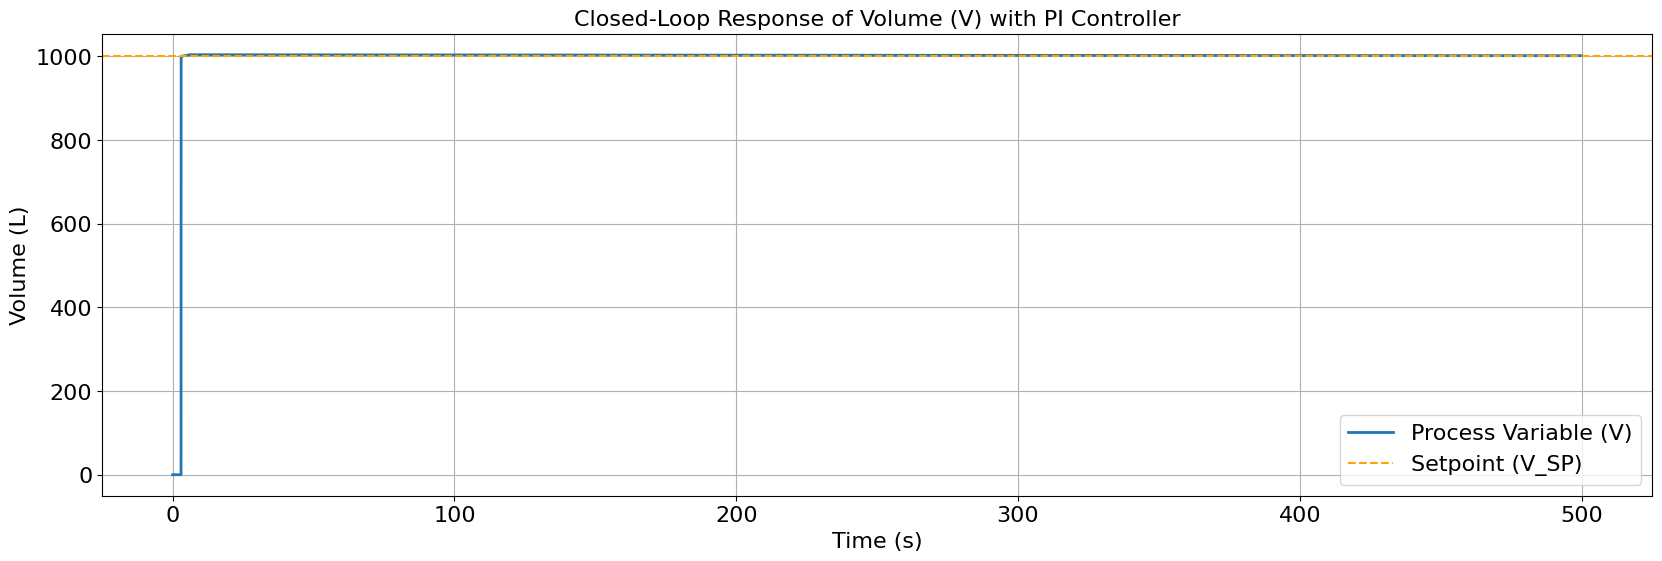

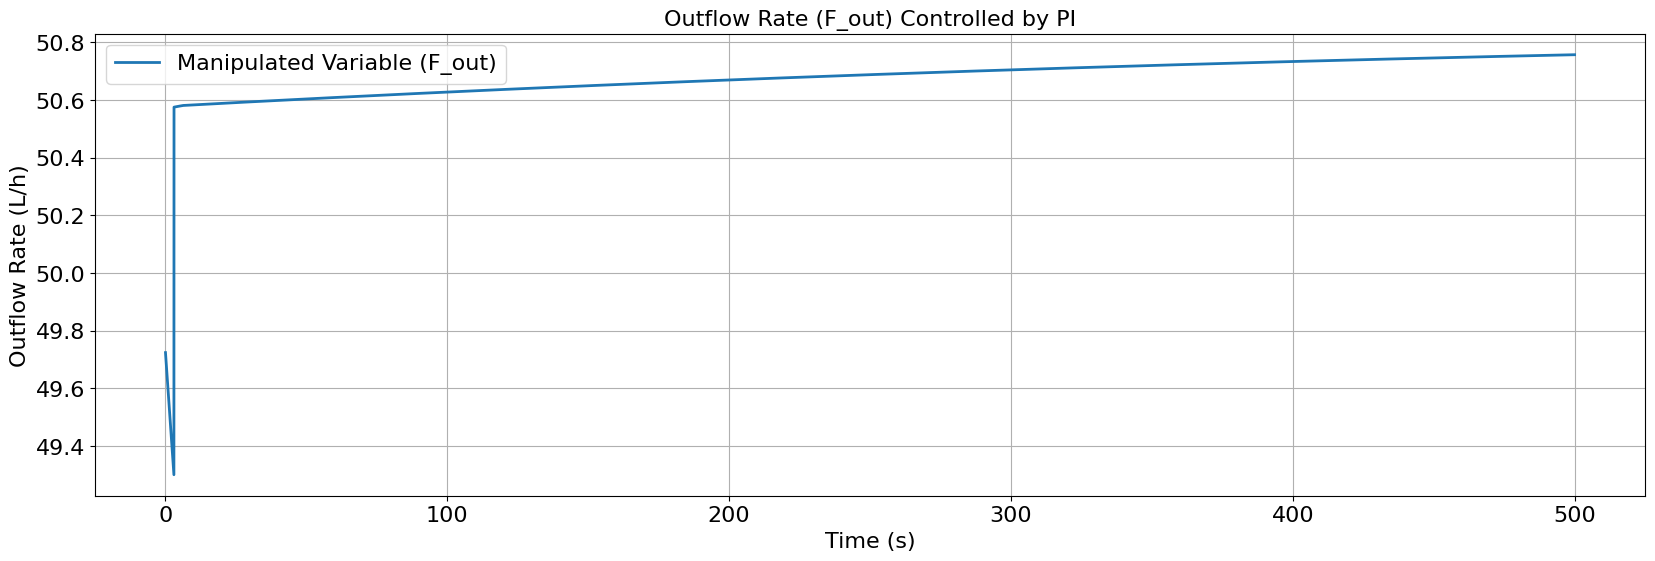

In [284]:
plt.figure(figsize=(20, 6))
plt.plot(t_PI, V_PI, label="Process Variable (V)", linewidth=2)
plt.axhline(V_SP, color='orange', linestyle='--', label="Setpoint (V_SP)")
plt.title("Closed-Loop Response of Volume (V) with PI Controller")
plt.xlabel("Time (s)")
plt.ylabel("Volume (L)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(20, 6))
plt.plot(t_PI, F_out_PI, label="Manipulated Variable (F_out)", linewidth=2)
plt.title("Outflow Rate (F_out) Controlled by PI")
plt.xlabel("Time (s)")
plt.ylabel("Outflow Rate (L/h)")
plt.legend()
plt.grid(True)
plt.show()


# Problem 4C

In [285]:
t_final = 2000
t_PI, result_PI = dynamic_model_with_PI([0, t_final], x0)

V_PI = result_PI[0, :]
C_X_PI = result_PI[1, :]
C_P_PI = result_PI[2, :]
C_S_PI = result_PI[3, :]
T_PI = result_PI[4, :]

T_PI = [t + 25 for t in T_PI]

-1.2764166666666668
-1.2764166666666668
-1.2764166666666668
-0.0014166666666666668
0.003044097916666426
0.004671529166666331
0.00629896041666609
0.006300766666666313
0.006296885441822376
0.006290929242134869
0.006282898067603939
0.006274864590103828
0.006266836061165715
0.006258815126381986
0.006250804431345891
0.006242803978993409
0.006234813763015559
0.006226833773729489
0.006218863998079631
0.0062109044230063614
0.006202955035458318
0.0061950158223970375
0.006187086770799424
0.006179167867660063
0.006171259099989775
0.006163360454816198
0.006155471919183491
0.006147593480152336
0.006139725124799655
0.006131866840219904
0.006124018613522905
0.006116180431835731
0.006108352282301688
0.0061005341520804605
0.006092726028348114
0.006084927898297819
0.006077139749138108
0.00606936156809433
0.006061593342408067
0.006053835059337716
0.0060460867061574745
0.006038348270158353
0.006030619738647018
0.006022901098946512
0.006015192338395973
0.0060074934443513466
0.005999804404184674
0.005992125

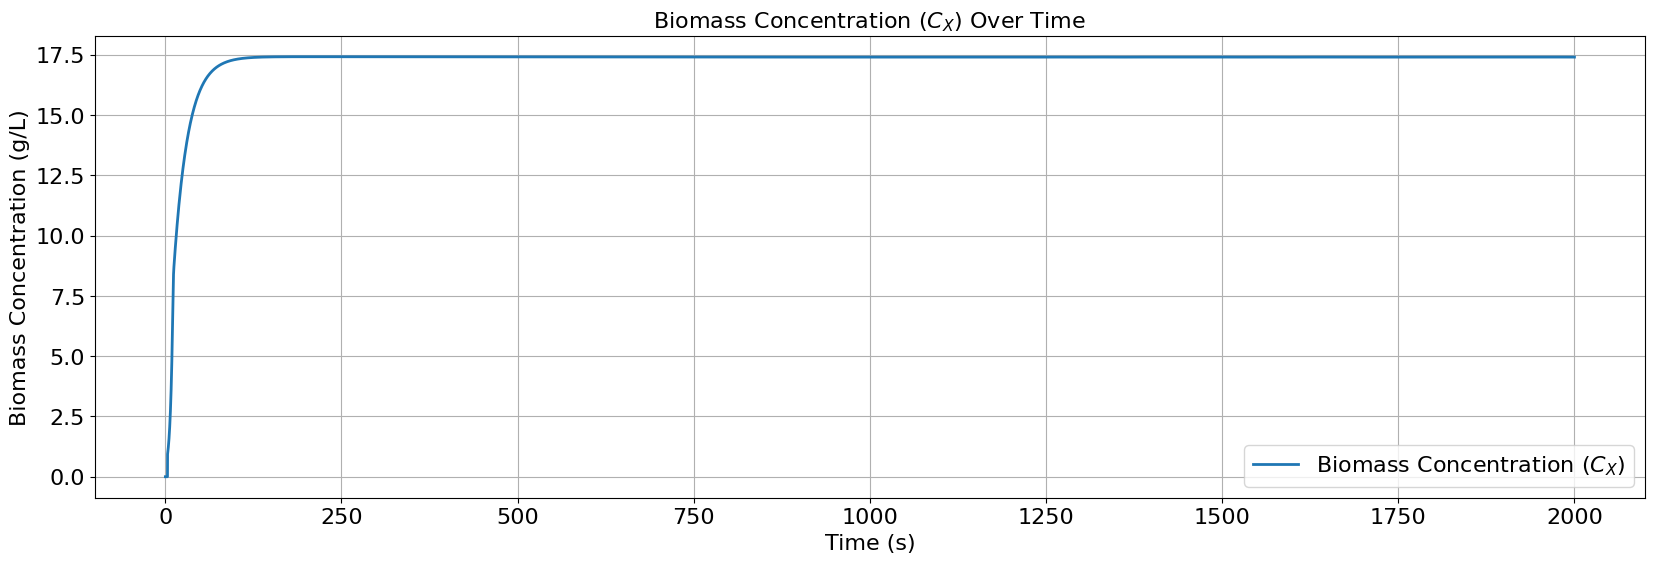

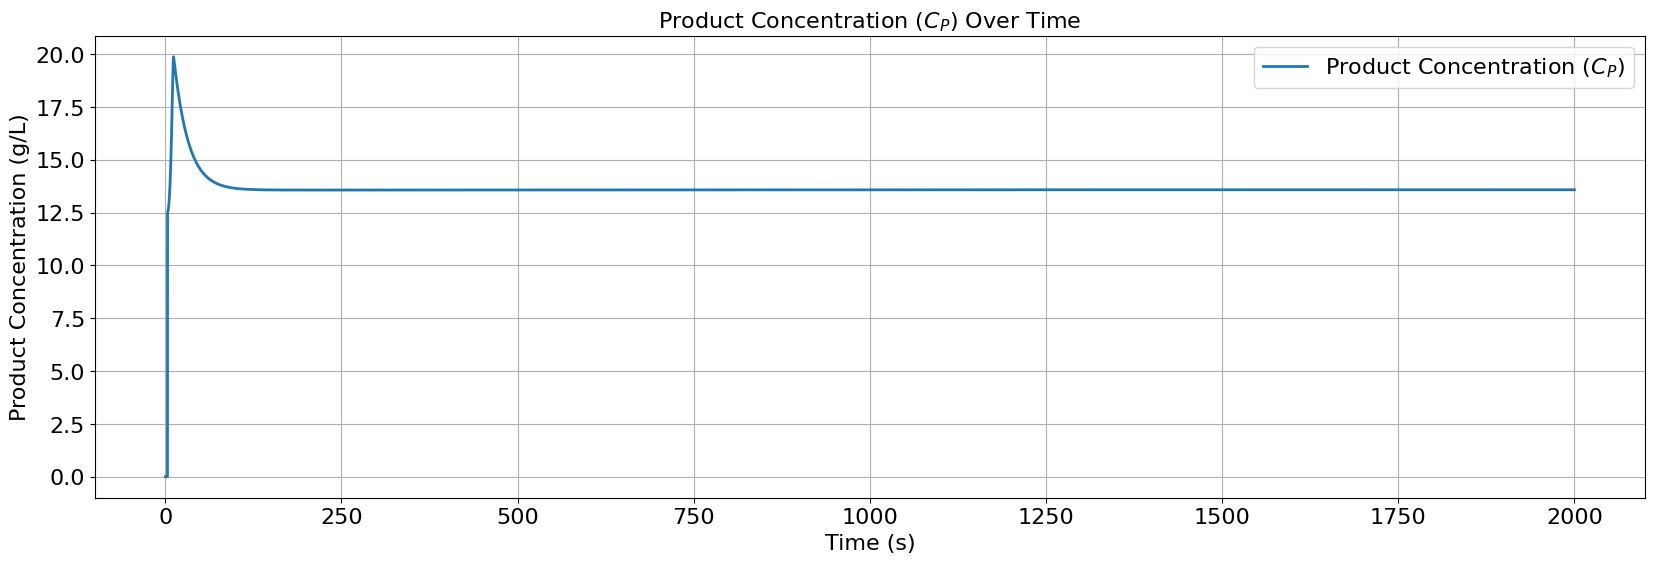

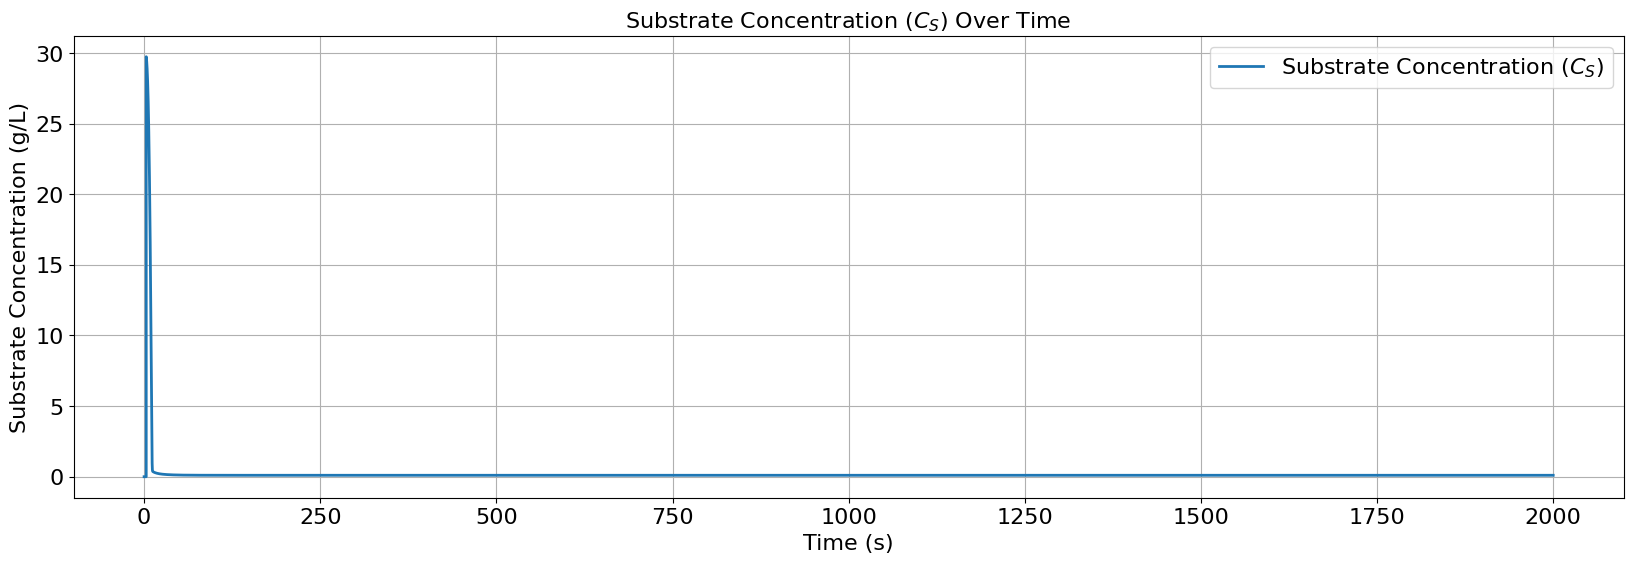

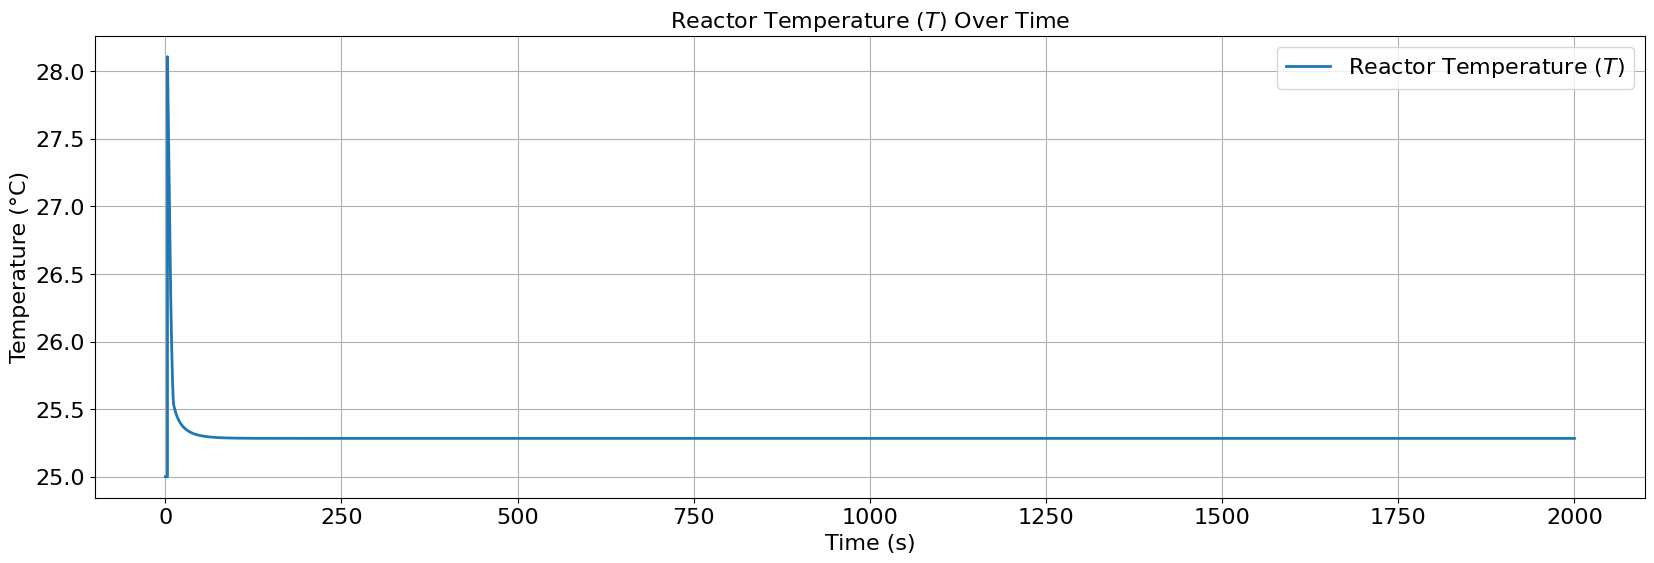

In [286]:

plt.figure(figsize=(20, 6))
plt.plot(t_PI, C_X_PI, label="Biomass Concentration ($C_X$)", linewidth=2)
plt.title("Biomass Concentration ($C_X$) Over Time")
plt.xlabel("Time (s)")
plt.ylabel("Biomass Concentration (g/L)")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(20, 6))
plt.plot(t_PI, C_P_PI, label="Product Concentration ($C_P$)", linewidth=2)
plt.title("Product Concentration ($C_P$) Over Time")
plt.xlabel("Time (s)")
plt.ylabel("Product Concentration (g/L)")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(20, 6))
plt.plot(t_PI, C_S_PI, label="Substrate Concentration ($C_S$)", linewidth=2)
plt.title("Substrate Concentration ($C_S$) Over Time")
plt.xlabel("Time (s)")
plt.ylabel("Substrate Concentration (g/L)")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(20, 6))
plt.plot(t_PI, T_PI, label="Reactor Temperature ($T$)", linewidth=2)
plt.title("Reactor Temperature ($T$) Over Time")
plt.xlabel("Time (s)")
plt.ylabel("Temperature (°C)")
plt.grid(True)
plt.legend()
plt.show()


# Problem 5A

#### See ~/project/linearized_model.ipynb to see linearized model

In [ ]:
def T_in_help(i):
    if i <= 20:
        return 25 * (20 - 25) * (i / 20) 
    elif 20 < i <= 50:
        return 30
    elif 50 < i <= 70:
        return 30 - (30 - 25) * ((i - 50) / 20)

In [ ]:
def dynamic_model_with_disturbance_T(time, x0):
    result_sp = set_point(time, x0)
    result = np.zeros((7, T_DELAY * (T_POINT - 1)))

    for i in range(time[1] - T_DELAY):
        if i == 0:
            x0 = x0
        
        V, Cx, Cp, Cs, Co2, T, Tag = current_output(i, result)
        Vsp, Cxsp, Cpsp, Cssp, Co2sp, Tsp, Tagsp = current_output(i, result_sp)

        T_in = lambda t: 25 if t < (20*60) else (35 if t <= (60*50) else 25)
        # T_in = lambda t: 25 * (20 - 25) * (i / 20) if i <= 20 else 30 if i <= 50 else 30 - (30 - 25) * ((i - 50) / 20)
        Fi = lambda t: 51
        Fe = lambda t: 51
        cS_in = lambda t: 60
        Fag = lambda t: 18
        
        result = solve_step([i, i + 1], x0, Fi, Fe, T_in, cS_in, Fag, result)
        x0 = result[:, -1]

    t = np.linspace(time[0], time[1], (time[1] - time[0]) * (T_POINT - 1) + 1)
    return t, result, result_sp


In [ ]:
x0 = [1000.0, 0.90467678228155, 12.51524128083789, 29.73892382828279, 3.10695341758232, 29.57321214183856, 27.05393890970931]
t_final = 4000

t_step, result_step, result_sp = dynamic_model_with_disturbance_T([0, t_final], x0)
T_step = result_step[5, :]

In [ ]:
plt.figure(figsize=(20, 6))
plt.plot(t_step, T_step, label="Reactor Temperature (T)", linewidth=2)
plt.axvline(1200, color='red', linestyle='--', label="Step Up at t=20 s")
plt.axvline(3000, color='blue', linestyle='--', label="Step Down at t=50 s")
plt.title("Reactor Temperature Response to Disturbance Profile in $T_{in}$")
plt.xlabel("Time (s)")
plt.ylabel("Reactor Temperature (°C)")
plt.legend()
plt.grid(True)
plt.show()

# problem 5B

In [ ]:
print(T_step[10000], "phase 1 temperature")
print(T_step[180000], "phase 2 temperature")
print(T_step[396000], "phase 3 temperature")

In [ ]:
K_1 = (T_step[180000] - T_step[10000]) / 10
K_2 = 1
K_3 = (T_step[39600] - T_step[180000]) / 10

delay = 3

kc_1 = 0.9 / (K_1 * delay)
kc_2 = 0.9 / (K_2 * delay)
kc_3 = 0.9 / (K_3 * delay)

tau_i = 3.3 * delay

In [ ]:
def T_in(i):
    if i <= 20:
        return 25 * (20 - 25) * (i / 20) 
    elif 20 < i <= 50:
        return 30
    elif 50 < i <= 70:
        return 30 - (30 - 25) * ((i - 50) / 20)

In [ ]:
def dynamic_model_T_step(time, x0):
    result_sp = set_point(time, x0)
    result = np.zeros([7, T_DELAY * (T_POINT - 1)])
    
    Fi = lambda t: 51
    Fe = lambda t: 51
    T_in = lambda t: 25
    cS_in = lambda t: 60
    Fag = lambda t: 18
    
    for i in range(time[1] - T_DELAY):
        if i == 0:
            x0 = x0  # Skip iterations before T_DELAY
        
        V, Cx, Cp, Cs, Co2, T, Tag = current_output(i, result)
        Vsp, Cxsp, Cpsp, Cssp, Co2sp, Tsp, Tagsp = current_output(i, result_sp)
        T_sp = 1.05 * Tsp

        result = solve_step([i, i + 1], x0, Fi, Fe, T_in, cS_in, Fag, result)
        x0 = result[:, -1]
    
    t = np.linspace(time[0], time[1], (time[1] - time[0]) * (T_POINT - 1) + 1)
    return t, result, result_sp


In [ ]:
t_final = 1000
t, result, result_sp = dynamic_model_T_step([0,t_final], x0) ### run the model

In [ ]:
T_r_step = result[5, :]
F_ag_step = result[6, :]

plt.figure(figsize=(20, 6))
plt.plot(F_ag_step, T_r_step, label="Reactor Temperature")
plt.ylabel("Reactor Temperature (°C)")
plt.xlabel("F_ag")
plt.legend()
plt.grid()
plt.legend()


In [ ]:
gain = (T_r_step[-1] - T_r_step[0]) / (F_ag_step[-1] - F_ag_step[0])
print(gain)

In [ ]:
def TC(T, Tag, Tsp, Tagsp, Kp, Ki, integral_error, dt, integral_min, integral_max, T_i_ag = 15):
    error = Tsp - T
    integral_error += error * dt
    integral_error = np.clip(integral_error, integral_min, integral_max)
    Tag_new = Tagsp + Kp * error + Ki * integral_error

    if 25 != Tag_new:
        F_ag = (-KT * AT * (T - Tag)) / (ccal * ro * (T_i_ag - Tag_new))
    else:
        F_ag = 0

    return F_ag, integral_error

In [ ]:
def dynamic_model_TC(time, x0):
    result_sp = set_point(time, x0)
    result = np.zeros([7, T_DELAY * (T_POINT - 1)])
    
    Fi = lambda t: 51
    Fe = lambda t: 51
    T_in = lambda t: 25
    cS_in = lambda t: 60
    F_ag_prev = 18  # Initial value for F_ag
    
    for i in range(time[1] - T_DELAY):
        if i == 0:
            x0 = x0  # Skip iterations before T_DELAY
        
        V, Cx, Cp, Cs, Co2, T, Tag = current_output(i, result)
        Vsp, Cxsp, Cpsp, Cssp, Co2sp, Tsp, Tagsp = current_output(i, result_sp)
        T_sp = 1.05 * Tsp

        error = T_sp - T
        TF = scipy.signal.TransferFunction([31.5 * 31.5, 31.5], [-1/10 * 31.5 * 30, 0])
        t_eval = np.linspace(i, i + 1, T_POINT)
        
        _, F_d, _ = scipy.signal.lsim(TF, error, t_eval)
        F_ag = F_d - (F_d[0] - F_ag_prev)
        F_ag_prev = F_ag[-1] 
        Fag = lambda t: F_ag[-1]
        T_in_func = lambda t: T_in(i)

        result = solve_step([i, i + 1], x0, Fi, Fe, T_in_func, cS_in, Fag, result)
        x0 = result[:, -1]
    
    t = np.linspace(time[0], time[1], (time[1] - time[0]) * (T_POINT - 1) + 1)
    return t, result, result_sp


In [ ]:
t_final = 100
t_TC, result_TC, result_sp_TC = dynamic_model_TC([0, t_final], x0)
T_TC = result_TC[5, :]

In [ ]:
plt.figure(figsize=(20, 6))
plt.plot(t_TC, T_TC)
plt.title("Reactor temperature with TC PI Controller")
plt.xlabel("time (s)")
plt.ylabel("Tank Temperature (C)")
plt.grid()
plt.legend()

# Problem 5C

In [ ]:
plt.figure(figsize=(20, 6))
plt.plot(t_TC, result_sp_TC[5, :], label="Setpoint (SP)", linestyle="--", color="blue")
plt.plot(t_TC, T_TC, label="Temperature in Reactor (PV)", color="red")
plt.title("Closed-Loop Response: Setpoint vs Process Variable")
plt.xlabel("Time (seconds)")
plt.ylabel("Temperature in Reactor (°C)")
plt.legend()
plt.grid()
plt.show()

F_ag = result_TC[6, :] 
plt.figure(figsize=(20, 6))
plt.plot(t_TC, F_ag, label="Manipulated Variable (MV)", color="green")
plt.title("Closed-Loop Response: Manipulated Variable")
plt.xlabel("Time (seconds)")
plt.ylabel("Jacket Flowrate in(L/min)")
plt.legend()
plt.grid()
plt.show()


# Problem 5D

In [ ]:
V_TC = result_TC[0, :]  # Reactor volume
Cx_TC = result_TC[1, :]  # Biomass concentration
Cp_TC = result_TC[2, :]  # Product concentration
Cs_TC = result_TC[3, :]  # Substrate concentration
Co2_TC = result_TC[4, :]  # CO2 concentration
Tj_TC = result_TC[6, :]  # Cooling jacket temperature

t = t_TC

plt.figure(figsize=(20, 6))
plt.plot(t, Cx_TC, label="Biomass Concentration (Cx)", color="blue")
plt.plot(t, Cp_TC, label="Product Concentration (Cp)", color="green")
plt.plot(t, Cs_TC, label="Substrate Concentration (Cs)", color="orange")
plt.title("Concentration Profiles")
plt.xlabel("Time (s)")
plt.ylabel("Concentration (mol/L)")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(20, 6))
plt.plot(t, Tj_TC, label="Cooling Jacket Temperature (Tj)", color="purple")
plt.title("Cooling Jacket Temperature")
plt.xlabel("Time (s)")
plt.ylabel("Temperature (°C) / Volume (L)")
plt.legend()
plt.grid()
plt.show()


plt.figure(figsize=(20, 6))
plt.plot(t, V_TC, label="Reactor Volume (V)", color="red")
plt.title("Reactor Volume")
plt.xlabel("Time (s)")
plt.ylabel("Temperature (°C) / Volume (L)")
plt.legend()
plt.grid()
plt.show()


plt.figure(figsize=(20, 6))
plt.plot(t, T_TC, label="Process Variable (PV, Reactor Temperature)", color="red")
plt.plot(t, result_sp_TC[5, :], label="Setpoint (SP)", linestyle="--", color="blue")
plt.title("Closed-Loop Response: Setpoint vs Process Variable")
plt.xlabel("Time (s)")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(20, 6))
plt.plot(t, result_TC[6, :], label="Manipulated Variable (MV, F_ag)", color="green")
plt.title("Closed-Loop Response: Manipulated Variable")
plt.xlabel("Time (s)")
plt.ylabel("Flowrate (L/min)")  # Update units if different
plt.legend()
plt.grid()
plt.show()


# Problem 6A

#### First, let's plot the response of C_p with no disturbance and a step change in C_s

In [ ]:
def dynamic_model_with_step_Cs(time, x0):
    result_sp = set_point(time, x0)
    result = np.zeros([7,T_DELAY*(T_POINT-1)])

    Fi = lambda t: 51
    Fe = lambda t: 51
    T_in = lambda t: 25*1.05
    cS_in = lambda t: 60
    Fag = lambda t: 18

    for i in range(time[1]-T_DELAY):

        if i == 0:
            x0=x0

        V, Cx, Cp, Cs, Co2, T, Tag = current_output(i,result) # find the current output of the process
        Vsp, Cxsp, Cpsp, Cssp, Co2sp, Tsp, Tagsp = current_output(i,result_sp) # Find the current setpoint of the process

        Cssp = 1.05 * Cssp

        t_eval = np.linspace(i,i+1,T_POINT) ## your transfer function should evaluate on the same time point as the model (this is your sampling point)
    
        result = solve_step([i, i+1], x0, Fi, Fe, T_in, cS_in, Fag, result)
        x0 = result[:,-1]
    t = np.linspace(time[0],time[1],(time[1] - time[0])*(T_POINT-1)+1) ## entire sampling time for the process 
    return t, result, result_sp


In [ ]:
t_final = 100 
t, result, result_sp = dynamic_model_with_step_Cs([0,t_final], x0)

In [ ]:
plt.figure(figsize=(20, 6))
plt.plot(t, result[2,:], label="Product Concentration (Cp)", color="green")
plt.plot(t, result_sp[2,:], label="Set Point", color="red", linestyle="--")
plt.title("Product Concentration Over Time with step change in Substrate concentration")
plt.xlabel("Time (s)")
plt.ylabel("Product Concentration (g/L)")
plt.legend()
plt.grid()

plt.figure(figsize=(20, 6))
plt.plot(result[3, :], result[2,:],label="Product Concentration (Cp)", color="purple")
plt.xlabel("Substrate Concentration (g/L)")
plt.ylabel("Product Concentration (g/L)")
plt.grid()
plt.legend()


In [ ]:
C_s_step, C_p_step = result[3, :], result[2,:]

gain = (C_p_step[-1] - C_p_step[0]) / -T_POINT* (C_s_step[-1] - C_s_step[0])
print(gain)

# Problem 6B

#### Now let's model our controller for C_s using this gain

In [ ]:
C_s_min, C_s_max = 0, 100
integral_min, integral_max = -10, 10
tauc = theta = 3
kc = (2* tauc + theta) / (gain * (tauc + theta) ** 2)
tau_i = 2* tauc + theta

def CC_small(Cp, Cpsp, C_p0, integral_error, dt):
    K = kc
    Ki = kc / tau_i
    error = Cpsp - Cp
    integral_error += error * dt
    integral_error = np.clip(integral_error, integral_min, integral_max)
    C_s_in = C_p0 + Kp * error + Ki * integral_error
    C_s_in = np.clip(C_s_in, C_s_min, C_s_max)
    return C_s_in, integral_error

In [ ]:
def CC(Cp, Cp_sp, C_p0, i, T_POINT):
    error = Cp_sp - Cp 
    TF = scipy.signal.TransferFunction([71.5*71.5, 71.5], [-1 / 10 * 31.5 * 30, 0])
    t_eval = np.linspace(i, i + 1, T_POINT)
    _, C_sd, _ = scipy.signal.lsim(TF, error, t_eval)
    C_s = C_sd - (C_sd[0] - C_p0)
    C_p0 = C_s[-1]
    cs_in = lambda t: C_s[-1]

    return C_s, C_p0, cs_in

# Problem 6C

#### (i): Small set point change in C_p

In [ ]:
def dynamic_model_small_setpoint_Cp(t, x0):
    result = np.zeros([7, T_DELAY * (T_POINT - 1)])
    C_p0 = 0
    Cpsp = 10
    global integral_error
    integral_error = 0
    dt = 1

    for i in range(t[1] - T_DELAY):
        if i == 0:
            x0 = x0
        
        V, Cx, Cp, Cs, Co2, T, Tag = current_output(i, result)
        Vsp, Cxsp, _, Cssp, Co2sp, Tsp, Tagsp = current_output(i, result_sp)
        Cpsp = 10
        C_s, integral_error = CC_small(Cp, Cpsp, C_p0, integral_error, dt)

        T_in = lambda t: 25
        Fi = lambda t: 51
        Fe = lambda t: 51
        cS_in = lambda t: 60
        Fag = lambda t: 18
        
        result = solve_step([i, i + 1], x0, Fi, Fe, T_in, C_s, Fag, result)
        x0 = result[:, -1]

    t = np.linspace(t[0], t[1], (t[1] - t[0]) * (T_POINT - 1) + 1)
    return t, result, result_sp


In [ ]:
t_final = 100
t_CC, result_CC, result_CC_sp = dynamic_model_small_setpoint_Cp([0, t_final], x0)
Cp_CC = result_TC[2, :]
Cp_CC_sp = result_CC[2, :]

In [ ]:
plt.figure(figsize=(20, 6))
plt.axhline(y=10, label="Set Point", color="red", linestyle="--")
plt.plot(t_CC, Cp_CC_sp, label="Controller Adjusted Set Point")
plt.plot(t_CC, Cp_CC, label="Product Concentration (Cp)")
plt.title("Product Concentration Over Time with step change in Substrate concentration")
plt.xlabel("Time (s)")
plt.ylabel("Product Concentration (g/L)")
plt.legend()
plt.grid()

#### (iii): Disturbance profile in C_s

#### First, we model the disturbance

In [ ]:
C_S0 = 60
amplitude = 25 / 2 
wavelength = 30

def C_s_fluctuation(i):
    return C_S0 + amplitude * np.cos(2 * np.pi * i / wavelength)

plt.figure(figsize=(20, 6))
plt.plot([i for i in range(60, 90)], [C_s_fluctuation(x) for x in range(60, 90)])

In [ ]:
def dynamic_model_Cs_fluctuation(t, x0):
    result = np.zeros([7, T_DELAY * (T_POINT - 1)])

    for i in range(t[1] - T_DELAY):
        if i == 0:
            x0 = x0
        
        V, Cx, Cp, Cs, Co2, T, Tag = current_output(i, result)
        Vsp, Cxsp, Cpsp, Cssp, Co2sp, Tsp, Tagsp = current_output(i, result_sp)

        T_in = lambda t: 25
        Fi = lambda t: 51
        Fe = lambda t: 51
        cS_in = lambda t: C_s_fluctuation(i)
        Fag = lambda t: 18
        
        result = solve_step([i, i + 1], x0, Fi, Fe, T_in, cS_in, Fag, result)
        x0 = result[:, -1]

    t = np.linspace(t[0], t[1], (t[1] - t[0]) * (T_POINT - 1) + 1)
    return t, result


In [ ]:
t_final = 200
t_Cs, result_Cs = dynamic_model_Cs_fluctuation([0, t_final], x0)

Cp_TC = result_Cs[2, :]  # Product concentration

In [ ]:
plt.figure(figsize=(20, 6))
plt.plot(t_Cs, Cp_TC, label="Product Concentration (Cp)", color="green")
plt.title("Product Concentration Over Time with Substrate Fluctuation")
plt.xlabel("Time (s)")
plt.ylabel("Product Concentration (g/L)")
plt.legend()
plt.grid()

#### Now let's implement our controller

In [ ]:
def dynamic_model_Cs_fluctuation_CC(time, x0):
    result_sp = set_point(time, x0)
    result = np.zeros([7, T_DELAY * (T_POINT - 1)])

    T_in = lambda t: 25
    Fi = lambda t: 51
    Fe = lambda t: 51
    Fag = lambda t: 18
    cS_in0 = 60
    C_p0 = 0

    for i in range(time[1] - T_DELAY):
        if i == 0:
            x0 = x0
        
        V, Cx, Cp, Cs, Co2, T, Tag = current_output(i, result)
        Vsp, Cxsp, Cpsp, Cssp, Co2sp, Tsp, Tagsp = current_output(i, result_sp)
        
        Cp_sp = 1.05 * Cpsp
        C_s, C_p0, _ = CC(Cp, Cpsp, C_p0, i, T_POINT)
        cs_in = lambda t: C_s_fluctuation(i)
        result = solve_step([i, i + 1], x0, Fi, Fe, T_in, cs_in, Fag, result)
        x0 = result[:, -1]

    t = np.linspace(time[0], time[1], (time[1] - time[0]) * (T_POINT - 1) + 1)
    return t, result, result_sp


In [ ]:
t_final = 100
t_CC, result_CC, result_CC_sp = dynamic_model_Cs_fluctuation_CC([0, t_final], x0)
Cp_CC = result_TC[2, :]
Cp_CC_sp = result_CC[2, :]

In [ ]:
plt.figure(figsize=(20, 6))
plt.plot(t_CC, Cp_CC, label="Product Concentration (Cp)", color="green")
plt.plot(t_CC, Cp_CC_sp, label="Set Point", color="red", linestyle="--")
plt.title("Product Concentration Over Time with Substrate Fluctuation")
plt.xlabel("Time (s)")
plt.ylabel("Product Concentration (g/L)")
plt.legend()
plt.grid()

# Problem 6C

In [ ]:
def dynamic_model_small_Cs_fluctuation(time, x0):
    result_sp = set_point(time, x0)
    result = np.zeros([7, T_DELAY * (T_POINT - 1)])

    T_in = lambda t: 25
    Fi = lambda t: 51
    Fe = lambda t: 51
    Fag = lambda t: 18
    cS_in0 = 60
    C_p0 = 0

    for i in range(time[1] - T_DELAY):
        if i == 0:
            x0 = x0
        
        V, Cx, Cp, Cs, Co2, T, Tag = current_output(i, result)
        Vsp, Cxsp, Cpsp, Cssp, Co2sp, Tsp, Tagsp = current_output(i, result_sp)
        Cp_sp = 1.05 * Cpsp
        C_s, C_p0, cs_in = CC(Cp, Cp_sp, C_p0, i, T_POINT)
        result = solve_step([i, i + 1], x0, Fi, Fe, T_in, cs_in, Fag, result)
        x0 = result[:, -1]

    t = np.linspace(time[0], time[1], (time[1] - time[0]) * (T_POINT - 1) + 1)
    return t, result, result_sp


In [ ]:
t_final = 100
t_CC, result_CC, result_CC_sp = dynamic_model_Cs_fluctuation([0, t_final], x0)
Cp_CC = result_TC[2, :]
Cp_CC_sp = result_CC[2, :]

In [ ]:
plt.figure(figsize=(20, 6))
plt.plot(t_CC, Cp_CC, label="Product Concentration (Cp)", color="green")
plt.plot(t_CC, Cp_CC_sp, label="Set Point", color="red", linestyle="--")
plt.title("Product Concentration Over Time with Substrate Fluctuation")
plt.xlabel("Time (s)")
plt.ylabel("Product Concentration (g/L)")
plt.legend()
plt.grid()